In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
# import fitsio
import pandas as pd
import time
import pickle

%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/rachel/Projects/survey-ops/')


In [3]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.src.environments import *
from survey_ops.src.offline_dataset import OfflineDECamDataset
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything


In [4]:
seed_everything(10)

# Load and cut data from fits file, save as .json

In [5]:
data_json_fn = '../data/data.json'
data_fits_fn = '../data/decam-exposures-20251107.fits.gz'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read('../data/decam-exposures-20251107.fits.gz')
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    print(df['datetime'].dtype)
    
    # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
    # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
    
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


# Configure model, data selection, and training setup

In [6]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

In [7]:
dataset = OfflineDECamDataset(
    df, 
    normalize_state=True,
    specific_years=[2014],
    specific_months=[12],
    specific_days=[15],
    binning_method='healpix',
    nside=8,
    bin_space='radec'
    # specific_days=np.arange(2, 4),
    # specific_filters=['r', 'g']
)

In [8]:
batch_size = 32
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [12]:
"""Algorithm and Train setup"""

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 64,
    'device': device,
    'lr': 3e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**alg_config)

fit_config = {
    'num_epochs' : 30,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'TelescopeEnv-v0'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config):
    exp_name = f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': dataset.normalize_state,
    'outdir': outdir
    }

agent = Agent(**agent_config)



# Train

In [13]:
start_time = time.time()
"""Train"""
agent.fit(
    dataloader=trainloader,
    **fit_config
    )
end_time = time.time()
train_time = end_time - start_time
print(f'Total train time = {train_time}s')

  0%|▌                                                                                                                              | 28/6870 [00:00<01:06, 102.89it/s]

Train step 0: Accuracy = 0.000, Loss = 6.6817, Q-val=0.000


  2%|██▉                                                                                                                           | 157/6870 [00:00<00:24, 279.10it/s]

Train step 100: Accuracy = 0.531, Loss = 1.3435, Q-val=0.000


  4%|████▌                                                                                                                         | 252/6870 [00:01<00:22, 298.74it/s]

Train step 200: Accuracy = 0.750, Loss = 0.9234, Q-val=0.000


  5%|██████▎                                                                                                                       | 347/6870 [00:01<00:21, 308.89it/s]

Train step 300: Accuracy = 0.594, Loss = 1.0245, Q-val=0.000


  6%|████████                                                                                                                      | 441/6870 [00:01<00:21, 300.45it/s]

Train step 400: Accuracy = 0.719, Loss = 0.8013, Q-val=0.000


  8%|█████████▊                                                                                                                    | 535/6870 [00:01<00:20, 302.19it/s]

Train step 500: Accuracy = 0.656, Loss = 0.6085, Q-val=0.000


 10%|████████████▏                                                                                                                 | 662/6870 [00:02<00:19, 313.03it/s]

Train step 600: Accuracy = 0.781, Loss = 0.8571, Q-val=0.000


 11%|█████████████▉                                                                                                                | 759/6870 [00:02<00:19, 318.27it/s]

Train step 700: Accuracy = 0.688, Loss = 0.5602, Q-val=0.000


 12%|███████████████▋                                                                                                              | 858/6870 [00:03<00:18, 318.20it/s]

Train step 800: Accuracy = 0.812, Loss = 0.4770, Q-val=0.000


 14%|█████████████████▍                                                                                                            | 952/6870 [00:03<00:20, 295.41it/s]

Train step 900: Accuracy = 0.844, Loss = 0.4964, Q-val=0.000


 15%|██████████████████▉                                                                                                          | 1042/6870 [00:03<00:19, 295.05it/s]

Train step 1000: Accuracy = 0.844, Loss = 0.7259, Q-val=0.000


 17%|████████████████████▋                                                                                                        | 1136/6870 [00:03<00:18, 305.02it/s]

Train step 1100: Accuracy = 0.719, Loss = 0.6032, Q-val=0.000


 18%|██████████████████████▉                                                                                                      | 1261/6870 [00:04<00:18, 299.88it/s]

Train step 1200: Accuracy = 0.906, Loss = 0.6375, Q-val=0.000


 20%|████████████████████████▋                                                                                                    | 1358/6870 [00:04<00:18, 305.95it/s]

Train step 1300: Accuracy = 0.781, Loss = 0.5114, Q-val=0.000


 21%|██████████████████████████▍                                                                                                  | 1452/6870 [00:04<00:17, 306.01it/s]

Train step 1400: Accuracy = 0.875, Loss = 0.3556, Q-val=0.000


 23%|████████████████████████████▏                                                                                                | 1548/6870 [00:05<00:16, 314.33it/s]

Train step 1500: Accuracy = 0.875, Loss = 0.3347, Q-val=0.000


 24%|█████████████████████████████▉                                                                                               | 1644/6870 [00:05<00:16, 307.75it/s]

Train step 1600: Accuracy = 0.719, Loss = 0.4425, Q-val=0.000


 25%|███████████████████████████████▌                                                                                             | 1737/6870 [00:05<00:16, 305.46it/s]

Train step 1700: Accuracy = 0.781, Loss = 0.4234, Q-val=0.000


 27%|█████████████████████████████████▉                                                                                           | 1862/6870 [00:06<00:16, 307.02it/s]

Train step 1800: Accuracy = 0.750, Loss = 0.2944, Q-val=0.000


 28%|███████████████████████████████████▌                                                                                         | 1957/6870 [00:06<00:16, 305.97it/s]

Train step 1900: Accuracy = 0.906, Loss = 0.5536, Q-val=0.000


 30%|█████████████████████████████████████▎                                                                                       | 2052/6870 [00:06<00:15, 311.05it/s]

Train step 2000: Accuracy = 0.750, Loss = 0.4876, Q-val=0.000


 31%|███████████████████████████████████████                                                                                      | 2150/6870 [00:07<00:14, 317.13it/s]

Train step 2100: Accuracy = 0.906, Loss = 0.3422, Q-val=0.000


 33%|████████████████████████████████████████▊                                                                                    | 2246/6870 [00:07<00:14, 308.89it/s]

Train step 2200: Accuracy = 0.875, Loss = 0.3830, Q-val=0.000


 34%|██████████████████████████████████████████▌                                                                                  | 2342/6870 [00:07<00:14, 309.73it/s]

Train step 2300: Accuracy = 0.875, Loss = 0.2161, Q-val=0.000


 35%|████████████████████████████████████████████▎                                                                                | 2437/6870 [00:08<00:14, 309.32it/s]

Train step 2400: Accuracy = 0.969, Loss = 0.4543, Q-val=0.000


 37%|██████████████████████████████████████████████▊                                                                              | 2570/6870 [00:08<00:13, 326.69it/s]

Train step 2500: Accuracy = 0.844, Loss = 0.2485, Q-val=0.000


 38%|███████████████████████████████████████████████▉                                                                             | 2637/6870 [00:08<00:13, 322.73it/s]

Train step 2600: Accuracy = 0.844, Loss = 0.4773, Q-val=0.000


 40%|█████████████████████████████████████████████████▊                                                                           | 2737/6870 [00:09<00:12, 327.74it/s]

Train step 2700: Accuracy = 0.875, Loss = 0.2500, Q-val=0.000


 41%|███████████████████████████████████████████████████▋                                                                         | 2839/6870 [00:09<00:12, 317.30it/s]

Train step 2800: Accuracy = 0.875, Loss = 0.2926, Q-val=0.000


 43%|█████████████████████████████████████████████████████▍                                                                       | 2937/6870 [00:09<00:12, 319.48it/s]

Train step 2900: Accuracy = 0.906, Loss = 0.2008, Q-val=0.000


 44%|███████████████████████████████████████████████████████▏                                                                     | 3032/6870 [00:10<00:13, 293.81it/s]

Train step 3000: Accuracy = 0.875, Loss = 0.3814, Q-val=0.000


 46%|█████████████████████████████████████████████████████████▌                                                                   | 3164/6870 [00:10<00:11, 319.33it/s]

Train step 3100: Accuracy = 0.969, Loss = 0.1916, Q-val=0.000


 47%|███████████████████████████████████████████████████████████▎                                                                 | 3262/6870 [00:10<00:11, 315.76it/s]

Train step 3200: Accuracy = 0.906, Loss = 0.2398, Q-val=0.000


 49%|█████████████████████████████████████████████████████████████                                                                | 3359/6870 [00:11<00:11, 317.86it/s]

Train step 3300: Accuracy = 1.000, Loss = 0.1526, Q-val=0.000


 50%|██████████████████████████████████████████████████████████████▊                                                              | 3454/6870 [00:11<00:11, 289.33it/s]

Train step 3400: Accuracy = 0.875, Loss = 0.2238, Q-val=0.000


 52%|████████████████████████████████████████████████████████████████▍                                                            | 3543/6870 [00:11<00:11, 286.44it/s]

Train step 3500: Accuracy = 0.844, Loss = 0.3255, Q-val=0.000


 53%|██████████████████████████████████████████████████████████████████▏                                                          | 3640/6870 [00:12<00:10, 308.37it/s]

Train step 3600: Accuracy = 0.844, Loss = 0.1212, Q-val=0.000


 54%|███████████████████████████████████████████████████████████████████▉                                                         | 3732/6870 [00:12<00:10, 293.44it/s]

Train step 3700: Accuracy = 0.906, Loss = 0.2368, Q-val=0.000


 56%|██████████████████████████████████████████████████████████████████████▎                                                      | 3862/6870 [00:12<00:09, 313.44it/s]

Train step 3800: Accuracy = 0.969, Loss = 0.1496, Q-val=0.000


 58%|███████████████████████████████████████████████████████████████████████▉                                                     | 3957/6870 [00:13<00:09, 303.09it/s]

Train step 3900: Accuracy = 0.875, Loss = 0.2099, Q-val=0.000


 59%|█████████████████████████████████████████████████████████████████████████▋                                                   | 4052/6870 [00:13<00:09, 307.02it/s]

Train step 4000: Accuracy = 0.875, Loss = 0.3974, Q-val=0.000


 60%|███████████████████████████████████████████████████████████████████████████▍                                                 | 4146/6870 [00:13<00:08, 304.25it/s]

Train step 4100: Accuracy = 0.938, Loss = 0.2181, Q-val=0.000


 62%|█████████████████████████████████████████████████████████████████████████████▏                                               | 4239/6870 [00:14<00:08, 298.88it/s]

Train step 4200: Accuracy = 0.969, Loss = 0.2334, Q-val=0.000


 63%|███████████████████████████████████████████████████████████████████████████████▎                                             | 4362/6870 [00:14<00:08, 301.58it/s]

Train step 4300: Accuracy = 0.906, Loss = 0.0981, Q-val=0.000


 65%|█████████████████████████████████████████████████████████████████████████████████                                            | 4453/6870 [00:14<00:08, 290.25it/s]

Train step 4400: Accuracy = 0.875, Loss = 0.1902, Q-val=0.000


 66%|██████████████████████████████████████████████████████████████████████████████████▋                                          | 4547/6870 [00:15<00:07, 300.88it/s]

Train step 4500: Accuracy = 0.906, Loss = 0.2035, Q-val=0.000


 68%|████████████████████████████████████████████████████████████████████████████████████▌                                        | 4645/6870 [00:15<00:07, 311.97it/s]

Train step 4600: Accuracy = 0.844, Loss = 0.2988, Q-val=0.000


 69%|██████████████████████████████████████████████████████████████████████████████████████▏                                      | 4738/6870 [00:15<00:07, 292.51it/s]

Train step 4700: Accuracy = 0.906, Loss = 0.2384, Q-val=0.000


 71%|████████████████████████████████████████████████████████████████████████████████████████▍                                    | 4861/6870 [00:16<00:06, 298.65it/s]

Train step 4800: Accuracy = 0.938, Loss = 0.2298, Q-val=0.000


 72%|██████████████████████████████████████████████████████████████████████████████████████████▏                                  | 4957/6870 [00:16<00:06, 309.31it/s]

Train step 4900: Accuracy = 0.906, Loss = 0.0607, Q-val=0.000


 74%|███████████████████████████████████████████████████████████████████████████████████████████▉                                 | 5053/6870 [00:16<00:05, 307.67it/s]

Train step 5000: Accuracy = 1.000, Loss = 0.1717, Q-val=0.000


 75%|█████████████████████████████████████████████████████████████████████████████████████████████▋                               | 5146/6870 [00:17<00:05, 300.41it/s]

Train step 5100: Accuracy = 0.969, Loss = 0.3150, Q-val=0.000


 76%|███████████████████████████████████████████████████████████████████████████████████████████████▍                             | 5243/6870 [00:17<00:05, 313.63it/s]

Train step 5200: Accuracy = 0.906, Loss = 0.1280, Q-val=0.000


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 5339/6870 [00:17<00:04, 309.28it/s]

Train step 5300: Accuracy = 1.000, Loss = 0.1414, Q-val=0.000


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 5432/6870 [00:17<00:04, 303.13it/s]

Train step 5400: Accuracy = 0.969, Loss = 0.2354, Q-val=0.000


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 5561/6870 [00:18<00:04, 306.60it/s]

Train step 5500: Accuracy = 1.000, Loss = 0.2455, Q-val=0.000


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 5654/6870 [00:18<00:04, 303.33it/s]

Train step 5600: Accuracy = 0.875, Loss = 0.0233, Q-val=0.000


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 5750/6870 [00:19<00:03, 312.13it/s]

Train step 5700: Accuracy = 1.000, Loss = 0.0996, Q-val=0.000


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 5845/6870 [00:19<00:03, 303.15it/s]

Train step 5800: Accuracy = 0.844, Loss = 0.2295, Q-val=0.000


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 5936/6870 [00:19<00:03, 286.29it/s]

Train step 5900: Accuracy = 0.938, Loss = 0.0980, Q-val=0.000


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 6052/6870 [00:20<00:02, 281.31it/s]

Train step 6000: Accuracy = 1.000, Loss = 0.0814, Q-val=0.000


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 6141/6870 [00:20<00:02, 286.64it/s]

Train step 6100: Accuracy = 1.000, Loss = 0.1336, Q-val=0.000


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 6258/6870 [00:20<00:02, 285.95it/s]

Train step 6200: Accuracy = 0.938, Loss = 0.0944, Q-val=0.000


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 6345/6870 [00:21<00:01, 284.26it/s]

Train step 6300: Accuracy = 1.000, Loss = 0.0389, Q-val=0.000


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 6433/6870 [00:21<00:01, 275.15it/s]

Train step 6400: Accuracy = 0.844, Loss = 0.0515, Q-val=0.000


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 6559/6870 [00:21<00:01, 299.93it/s]

Train step 6500: Accuracy = 1.000, Loss = 0.0333, Q-val=0.000


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 6651/6870 [00:22<00:00, 287.38it/s]

Train step 6600: Accuracy = 0.938, Loss = 0.0710, Q-val=0.000


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 6742/6870 [00:22<00:00, 296.44it/s]

Train step 6700: Accuracy = 0.969, Loss = 0.0431, Q-val=0.000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 6838/6870 [00:22<00:00, 308.05it/s]

Train step 6800: Accuracy = 0.938, Loss = 0.2212, Q-val=0.000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6870/6870 [00:22<00:00, 300.12it/s]

Total train time = 23.0680890083313s


In [15]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

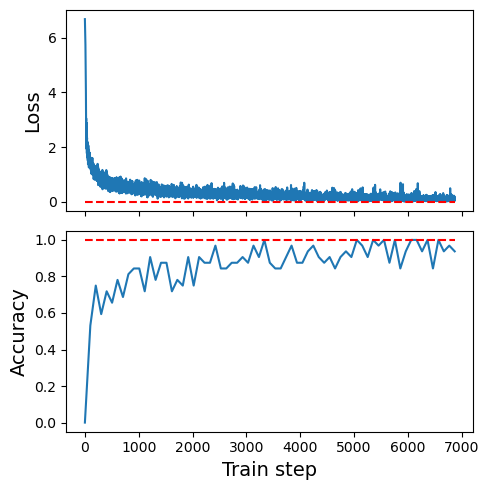

In [16]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Evaluate

In [17]:
dataset._df

,expnum,ra,dec,exptime,filter,propid,program,teff,fwhm,datetime,az,zd,ha,airmass,qc_fwhm,qc_cloud,qc_sky,qc_teff,timestamp,night
27072,388089,14.146454,-23.259666,90,i,2012B-0001,survey,0.217822,0.93,2014-12-16 00:52:25,299.064514,13.180000,12.575042,1.03,0.93,0.16,0.41,0.64,1418691145,2014-12-15
27073,388090,13.226792,-20.689693,90,i,2012B-0001,survey,0.257426,0.94,2014-12-16 00:54:25,304.028290,15.790000,13.996000,1.04,0.94,0.15,0.33,0.68,1418691265,2014-12-15
27074,388091,16.641497,-20.689667,90,i,2012B-0001,survey,0.356436,0.92,2014-12-16 00:56:29,311.268799,13.810000,11.101042,1.03,0.92,0.12,0.22,0.78,1418691389,2014-12-15
27075,388092,15.916125,-24.274195,90,i,2012B-0001,survey,0.396040,0.93,2014-12-16 00:58:37,295.712494,12.460000,12.360375,1.02,0.93,0.17,0.15,0.82,1418691517,2014-12-15
27076,388093,22.759968,-63.111832,90,i,2012B-0001,survey,0.366337,0.93,2014-12-16 01:02:06,185.262207,33.110001,6.392042,1.19,0.93,0.07,0.18,0.79,1418691726,2014-12-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27296,388313,87.871780,-26.776583,90,i,2012B-0001,survey,0.356436,1.00,2014-12-16 08:16:48,261.519196,43.919998,50.274582,1.39,1.00,-0.19,0.04,0.78,1418717808,2014-12-15
27297,388314,89.161125,-28.619581,90,i,2012B-0001,survey,0.287129,1.05,2014-12-16 08:18:46,259.210114,42.740002,49.476044,1.36,1.05,-0.24,0.04,0.71,1418717926,2014-12-15
27298,388315,89.161171,-28.619499,45,Y,2012B-0001,survey,0.445545,1.05,2014-12-16 08:20:43,259.073395,43.090000,49.893833,1.37,1.05,-0.03,-0.29,0.87,1418718043,2014-12-15
27299,388316,90.091995,-29.042250,90,z,2012B-0001,survey,0.405941,0.98,2014-12-16 08:21:56,258.649414,42.509998,49.335251,1.36,0.98,-0.05,-0.06,0.83,1418718116,2014-12-15


In [18]:
import random

In [19]:
eval_actions = []
# success_sequence = []
azel_sequence = [(az, el) for az, el in zip (dataset.states[:, 0], dataset.states[:, 1])]

with torch.no_grad():
    for i, state in enumerate(dataset.states):
        q_vals = agent.algorithm.policy_net(state.to(device)).unsqueeze(0)
        action = torch.argmax(q_vals, dim=1).item()
        eval_actions.append(action)
        
        # candidates_in_bin = np.array(dataset.id2azel[action])
        # success_sequence.append(azel_sequence[i] in candidates_in_bin)


In [20]:
first_obs_in_night_indices = []
for key, indices in dataset._groups.indices.items():
    first_obs_in_night_indices.append(indices[0])

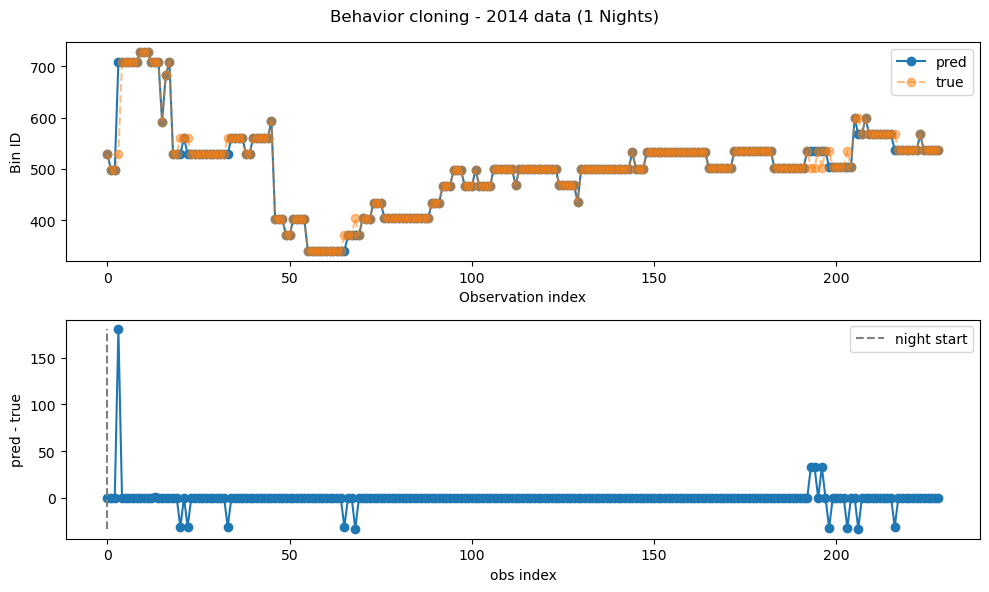

In [21]:
target_sequence = dataset.actions.detach().numpy()
eval_sequence = eval_actions
mask_first_obs = dataset.states[:, 0] == 0. 

fig, axs = plt.subplots(2, figsize=(10,6))
axs[0].plot(eval_sequence, marker='o', label='pred')
axs[0].plot(target_sequence, marker='o', linestyle='dashed', label='true', alpha=.5)
axs[0].set_xlabel('Observation index')
axs[0].set_ylabel('Bin ID')
axs[0].legend()

axs[1].plot(eval_sequence - target_sequence, marker='o')
axs[1].vlines(first_obs_in_night_indices, ymin=np.min(eval_sequence - target_sequence), ymax=np.max(eval_sequence - target_sequence), linestyle='--', color='grey', label='night start')
axs[1].legend()
axs[1].set_xlabel('obs index')
axs[1].set_ylabel('pred - true')

fig.tight_layout()
fig.suptitle(f'Behavior cloning - 2014 data ({dataset.n_nights} Nights)')
fig.tight_layout()
fig.savefig(fig_outdir + 'learned_sequence.png')

In [23]:
len(eval_sequence)

229

In [24]:
len(target_sequence)

229

In [33]:
dataset.unique_nights

dict_keys([Timestamp('2014-12-15 00:00:00')])

In [37]:
def save_schedule_for_video(outdir, df, hpGrid, policy_bin_ids, original_bin_ids, return_outputs=False):
    # def produce_schedule_for_video(outdir, id2radec):
    field_filepath = outdir + '2014-12-15_fields2radec.json' # field id to ra_dec
    schedule_filepath = outdir + '2014-12-15_schedule.csv' # keys time and field_id

    timestamps = df['timestamp'].values.tolist()
    id2radec = {i: np.float64([ra, dec]).tolist() for i, (ra, dec) in enumerate(zip(hpGrid.lon, hpGrid.lat))}
    
    # save field_to_radec
    with open(field_filepath, 'w') as f:
        json.dump(id2radec, f, indent=2)
    
    # save time, field_id, next_field_id
    data = {'time': timestamps, 'policy_bin_id': policy_bin_ids, 'bin_id': original_bin_ids}
    schedule_df = pd.DataFrame(data)
    schedule_df.to_csv(schedule_filepath, index=False)

    if return_outputs:
        return id2radec, schedule_df

In [45]:
id2radec, schedule_df = save_schedule_for_video(
    '../data/', 
    dataset._df,
    dataset.hpGrid,
    policy_bin_ids=eval_sequence,
    original_bin_ids=target_sequence,
    return_outputs=True
)

In [46]:
schedule_df

,time,policy_bin_id,bin_id
0,1418691145,529,529
1,1418691265,497,497
2,1418691389,497,497
3,1418691517,709,529
4,1418691726,709,709
...,...,...,...
224,1418717808,536,536
225,1418717926,536,536
226,1418718043,536,536
227,1418718116,536,536
